In [72]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothic')
plt.style.use('ggplot')
plt.rc('font', size=15)

from tqdm import tqdm_notebook

from eunjeon import Mecab

from gensim.models import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
import gensim
gensim.__version__  # '3.8.3'

from sklearn.decomposition import PCA

'3.8.3'

In [32]:
import preprocess_kr

In [33]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

In [34]:
import warnings
warnings.filterwarnings('ignore')

In [35]:
# 전처리된 정제된 파일을 사용한다.
df = pd.read_table('./data/kr_전지적 독자 시점_episode_total_cleaned_list.txt', header =None)

In [36]:
df.columns = ['Review']
df.head()

,Review
0,전설이 시작된다
1,전독시 소설은 안봤는데 이거 재밌움 웨툰은 일단 존잼
2,나는유중혁이다
3,소설은 완결났길래 이것도 완결 가까워지면 몰아보려고 하는데 지금 전개가 소설 몇화쯤인가요
4,정주행가는중


# mecab 토큰화 및 불용어 제거

In [94]:
def get_tokenized_data(df):
    """
    mecab 형태소 분석기를 이용하여 토큰화 및 불용어 제거하는 함수¶
    """
    
    # 불용어 생성
    stopwords = preprocess_kr.make_stop_words()

    # mecab 형태소 분석기 객체 생성 
    mecab = Mecab()

    # 결과 리스트
    tokenized_data = []

    # 원래 진행하고자했던 반복문 for i in range(100)에서 'in' 뒤에 문장을 tqdm()으로 감싸주면 진행 상황이 bar로 표현된다.
    # tqdm_notebook 은 tqdm 의 Jupiter Notebook version, progress bar가 예쁘다.
    for sentence in tqdm_notebook(df['Review']):
        tokenized_sentence = mecab.morphs(sentence) # mecab 문장 토큰화

        stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거    
        stopwords_removed_sentence = [word for word in stopwords_removed_sentence if len(word) > 1] # 한글자 제거

        tokenized_data.append(stopwords_removed_sentence)
        
    return tokenized_data

def show_review_info(tokenized_data):
    """
    리뷰 길이 분포 확인 함수
    """
    print('리뷰의 최대 길이 :',max(len(review) for review in tokenized_data))
    print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
    plt.hist([len(review) for review in tokenized_data], bins=50)
    plt.xlabel('length of samples')
    plt.ylabel('number of samples')
    plt.show()
    
def get_model_wv(tokenized_data):
    """
    토큰화된 데이터를 Word2Vec 알고리즘을 학습시켜 모델을 반환하는 함수
    """
    # Word2Vec으로 토큰화된 tokenized_data를 학습
    from gensim.models import Word2Vec
    # gensim 4.2 vector_size
    # gensim 3.8.3 size
    model = Word2Vec(sentences = tokenized_data, size = 100, window = 5, min_count = 5, workers = 4, sg = 0)
    
    # Word2Vec 임베딩 행렬의 크기를 확인
    print("model.wv.vectors.shape: ",model.wv.vectors.shape)
    
    return model    

def print_most_similar_words(model, words_list): 
    """
    특정단어 리스트를 입력받아 유사도를 출력하는 함수
    """
    for keyword in words_list:        
        print('[', keyword, '] 와 관련있는 단어들 :' , model.wv.most_similar(keyword))
        print()
        
def get_similarity_btw_two_words(model, w1,w2):
    """
    단어간 유사도 확인 함수
    """
    
    # 모델로부터 단어벡터를 구한다.
    word_vectors = model.wv
    
    vocabs = word_vectors.vocab.keys()
    word_vectors_list = [word_vectors[v] for v in vocabs]

    # 단어간 유사도를 반환
    return word_vectors.similarity(w1, w2)
        
def get_similarity_df(keyword):
    """
    특정 키워드를 입력받아 관련있는 단어를 찾고 유사도를 구하는 함수
    """
    similar_word = model.wv.most_similar(keyword)
    similar_word_df = pd.DataFrame(similar_word)
    similar_word_df.columns=["유사단어","유사도"]
    similar_word_df
    return similar_word_df   

def plot_2d_graph(vocabs, xs, ys):
    """
    단어와 2차원 X축의 값, Y축의 값을 입력받아 2차원 그래프를 그리는 함수
    """
    plt.figure(figsize=(10,10))
    plt.scatter(xs, ys, marker = 'o')
    for i, v in enumerate(vocabs):
        plt.annotate(v, xy=(xs[i], ys[i]))    
        
def reduce_dimension_PCA(word_vectors_list):
    """
    PCA를 이용하여 차원을 축소하는 함수
    """
    pca = PCA(n_components=2)
    xys = pca.fit_transform(word_vectors_list[:10])
    xs = xys[:,0]
    ys = xys[:,1]
    return xs, ys        

# 1. 토큰화

In [39]:
tokenized_data = get_tokenized_data(df)
tokenized_data[:10]

stop_words made


  0%|          | 0/553692 [00:00<?, ?it/s]

[['전설', '시작'],
 ['독시', '소설'],
 ['유중'],
 ['소설', '완결', '완결', '가까워', '전개', '소설'],
 ['정주', '행가'],
 ['독시', '웹툰', '소설', '그림', '별론데', '그림', '체고', '독시', '만들', '함하', '사랑'],
 ['작가', '결말'],
 ['전독',
  '댓글',
  '당하',
  '댓글',
  '들어온',
  '화면',
  '확인',
  '수가',
  '답글',
  '제외',
  '답글',
  '유독',
  '답글',
  '보인다면',
  '내용',
  '차단',
  '도록',
  '개꿀',
  '기억',
  '기분',
  '망치',
  '전체',
  '댓글',
  '수로',
  '구분',
  '으므로',
  '장합'],
 ['독자', '못생긴', '설정'],
 ['정주', '시작']]

# 2. 댓글 정보 확인

리뷰의 최대 길이 : 250
리뷰의 평균 길이 : 4.3016767444716555


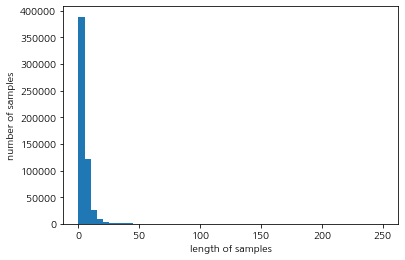

In [45]:
show_review_info(tokenized_data)

# 3. tokenized_data로 모델을 학습

In [46]:
model = get_model_wv(tokenized_data)

model.wv.vectors.shape:  (21323, 100)


In [47]:
# 모델을 저장한다.
model.save('word2vec.model')
 
# 저장한 모델을 읽어온다.
model = Word2Vec.load('word2vec.model')

# 4. 유사단어 검색

In [55]:
words_list = ['독자', '소설', '작가', '그림', '연출', '주인공', '캐릭터', '원작', '작화', '스토리']
print_most_similar_words(model, words_list)

[ 독자 ] 와 관련있는 단어들 : [('침착', 0.5694243907928467), ('독주', 0.5642824769020081), ('이수경', 0.5599619150161743), ('위로', 0.559868335723877), ('유중', 0.554161548614502), ('살아난', 0.5440741777420044), ('살아나', 0.5431872606277466), ('의지', 0.5323842167854309), ('일행', 0.52546226978302), ('초점', 0.5192813873291016)]

[ 소설 ] 와 관련있는 단어들 : [('원작', 0.783042311668396), ('완독', 0.6916880011558533), ('워낙', 0.6858994960784912), ('새롭', 0.6586625576019287), ('따라가', 0.6547131538391113), ('아무래도', 0.6529232263565063), ('아쉬운', 0.6500277519226074), ('지루', 0.649256706237793), ('재미', 0.645474910736084), ('봤었', 0.6419855356216431)]

[ 작가 ] 와 관련있는 단어들 : [('작업', 0.6657629609107971), ('신가요', 0.6632475256919861), ('리티', 0.6477935910224915), ('건강', 0.6444308757781982), ('힘드실', 0.640278160572052), ('슬리피', 0.6371983289718628), ('원작자', 0.6330706477165222), ('계신', 0.6255283355712891), ('오래오래', 0.6193499565124512), ('수익', 0.6135528087615967)]

[ 그림 ] 와 관련있는 단어들 : [('작화', 0.7689207792282104), ('신다', 0.7156005501747131), ('필력', 0.685

#  5. 단어간 유사도 확인

In [90]:
get_similarity_btw_two_words(model, '독자','수영')

0.39833376

# 6. 유사단어와 유사도를 데이터프레임으로 확인

In [91]:
similar_word_df = get_similarity_df('스토리')
similar_word_df

,유사단어,유사도
0,흐름,0.749422
1,구성,0.748187
2,흘러가,0.736642
3,흥미,0.733089
4,긴장감,0.728242
5,깔끔,0.724765
6,지루,0.723828
7,각색,0.722737
8,전개,0.718012
9,참신,0.717480


# 7. PCA 차원 축소 및 유사도 시각화

IndexError: index 10 is out of bounds for axis 0 with size 10

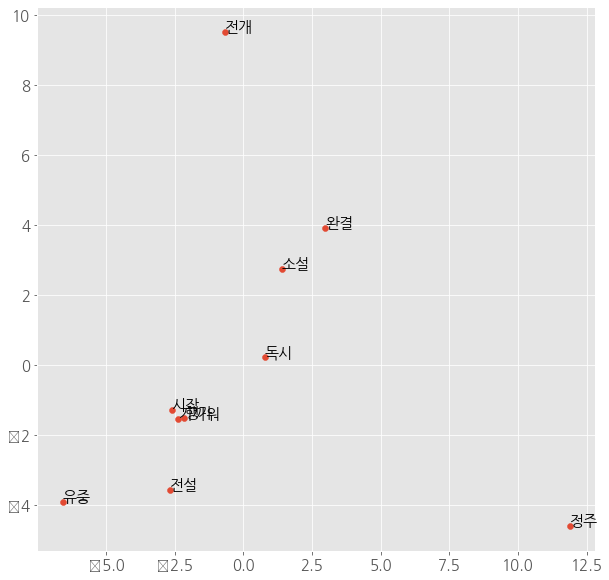

In [95]:
xs, ys = reduce_dimension_PCA(word_vectors_list)
plot_2d_graph(vocabs, xs, ys)